## Importing useful libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import re
import nltk
import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot,Tokenizer
from keras.models import Sequential
from keras.layers import LSTM,Dense,Embedding

## Loading dataset

In [2]:
df = pd.read_csv('cyberbullying_tweets.csv')
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


## EDA and Data Preprocessing

In [3]:
df.shape

(47692, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [5]:
df.duplicated().sum()

36

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.columns = ['tweet','type']

In [8]:
df['type'].value_counts()

religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: type, dtype: int64

In [9]:
df.iloc[20:22,0]

20    @halalcunty @biebervalue @liamxkiwi @greenline...
21    Kids Love😘❤ @ Mohamad Bin Zayed City مدينة محم...
Name: tweet, dtype: object

In [10]:
df = df.sample(frac=1).reset_index(drop=True)

In [11]:
df.head()

,tweet,type
0,Last in this session is Anthony Pratcher (Brow...,ethnicity
1,I have a sad story.Today I was having a conver...,age
2,You’re the idiot making generalizations about ...,religion
3,Rioting is dumb as fuck...but niggers love tha...,ethnicity
4,@desertfox899 woops!,not_cyberbullying


<Axes: xlabel='type', ylabel='count'>

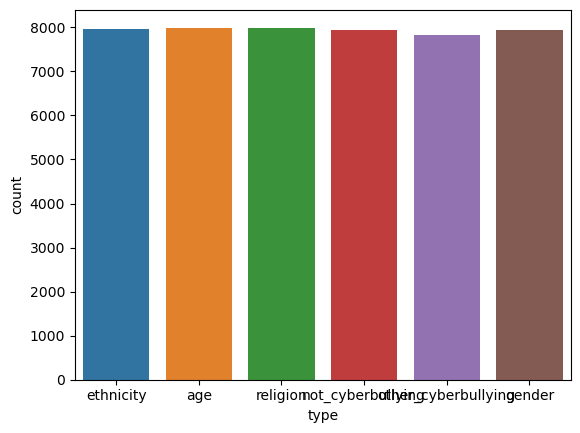

In [12]:
sns.countplot(x=df['type'])

In [13]:
df['tweet'][33]

'“@tayyoung_: FUCK OBAMA, dumb ass nigger” &lt;—— tight'

In [14]:
df['type'][33]

'ethnicity'

In [15]:
# Lowercasing
# Removing Punctuation & Special Characters
# removing single character
# removing multiple spaces
# Stop-Words Removal
# Removal of URLs
# Removal of HTML Tags
# Stemming & Lemmatization
# Tokenization
# Text Normalization

In [16]:

def preprocess_text(sentence):
    tag_pattern = re.compile(r'<.*?>')
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    # Lowercasing
    sent = sentence.lower()
    # Removal of HTML Tags
    sent = re.sub(tag_pattern, '', sent)
    # Removing Punctuation & Special Characters
    sent = re.sub('[^a-zA-Z]',' ',sent)
    # removing single character
    sent = re.sub(r"\s+[a-zA-Z]\s+",' ',sent)
    # removing multiple spaces
    sent = re.sub(r'\s+',' ',sent)
    # Removal of URLs
    sent = re.sub(url_pattern,'',sent)
    return sent
    

In [17]:
X = []
corpus = list(df['tweet'])
for line in corpus:
    X.append(preprocess_text(line))

In [18]:
X[33]

' tayyoung fuck obama dumb ass nigger lt tight'

In [19]:
y = df['type'].map({'other_cyberbullying':0,'not_cyberbullying':1,'gender':2,'ethnicity':3,'age':4,'religion':5})

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20,random_state=42)

## Converting sent into tokens and assigning them integers

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

input_dim = len(tokenizer.word_index) + 1

## Padding sent to ensure they're of same length

In [23]:
maxlen = 100
X_train = pad_sequences(X_train,padding='pre',maxlen = maxlen)
X_test = pad_sequences(X_test,padding='pre',maxlen = maxlen)

In [24]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


## Loading word2Vec and creating embedding matrix

In [25]:
wv = api.load('glove-twitter-100')

[==================================================] 100.0% 387.1/387.1MB downloaded


In [26]:
embedding_matrix = np.zeros((input_dim,100))
for word,index in tokenizer.word_index.items():
    if word in wv:
        embedding_matrix[index] = wv[word]

## Building the model

In [27]:
model = Sequential([
    Embedding(input_dim = input_dim,output_dim = 100,weights = [embedding_matrix],input_length = maxlen,trainable = False),
    LSTM(128),
    Dense(6,activation = 'softmax')
])

In [28]:
model.compile(optimizer = 'adam',loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

## Fitting the model

In [29]:
history = model.fit(X_train,y_train,batch_size = 128,epochs = 15, verbose = 1,validation_split = 0.2)

Epoch 1/15


239/239 [==============================] - 73s 218ms/step - loss: 0.7185 - accuracy: 0.7222 - val_loss: 0.5208 - val_accuracy: 0.7945
Epoch 2/15
239/239 [==============================] - 49s 205ms/step - loss: 0.4851 - accuracy: 0.8069 - val_loss: 0.4726 - val_accuracy: 0.8117
Epoch 3/15
239/239 [==============================] - 47s 198ms/step - loss: 0.4345 - accuracy: 0.8242 - val_loss: 0.4399 - val_accuracy: 0.8199
Epoch 4/15
239/239 [==============================] - 47s 198ms/step - loss: 0.4017 - accuracy: 0.8380 - val_loss: 0.4252 - val_accuracy: 0.8281
Epoch 5/15
239/239 [==============================] - 49s 205ms/step - loss: 0.3756 - accuracy: 0.8465 - val_loss: 0.4226 - val_accuracy: 0.8231
Epoch 6/15
239/239 [==============================] - 49s 206ms/step - loss: 0.3568 - accuracy: 0.8552 - val_loss: 0.4189 - val_accuracy: 0.8317
Epoch 7/15
239/239 [==============================] - 49s 205ms/step - loss: 0.3417 - accuracy: 0.8606 - val_loss: 0.3978 - val_

In [30]:
model_score = model.evaluate(X_test,y_test)
print(f"Model's test loss: {model_score[0]}")
print(f"Model's test accuracy: {model_score[1]}")

298/298 [==============================] - 10s 30ms/step - loss: 0.4663 - accuracy: 0.8196
Model's test loss: 0.4662594795227051
Model's test accuracy: 0.8195551633834839


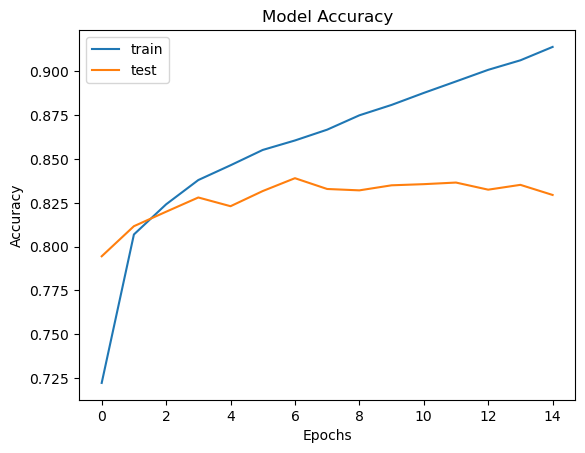

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

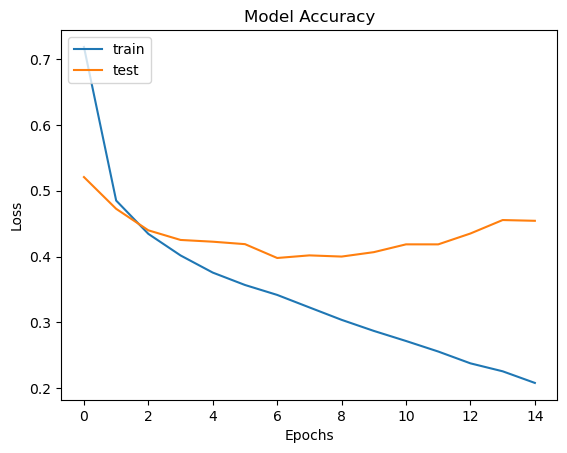

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

## Defining a predictor for user's input

In [33]:
inp = "The thing about Uber is, even if it wasn't a horrible, sexist, shitty company, I would still be against it."
x = []
x.append(preprocess_text(inp))

In [34]:
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x,padding='pre',maxlen = 100)

In [37]:
prediction = model.predict(x)[0]
predicted_class = np.argmax(prediction)
predicted_class

1/1 [==============================] - 0s 197ms/step


1

## Saving model and tokenizer

In [38]:
import pickle
pickle.dump(tokenizer,open('tokenizer.pkl','wb'))

C:\Users\odhia\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
model.save('twittModel.keras')